# Capstone Project - Queens

## Table of Contents

1.  <a href="#item1">Introduction: Business Problem</a>

2.  <a href="#item2">Data</a>

3.  <a href="#item3">Methodology</a>

4.  <a href="#item4">Analysis</a>

5.  <a href="#item5">Results and Discussion</a> 

6.  <a href="#item6">Conclusion</a> 

## Introduction: Business Problem <a name="introduction"></a>

A fastfood chain is interested in expanding to Queens. They want to open a few new restaurants and would like to find out the best neighborhoods to do so.


In order to answer that question, we first need to analyse the different neighborhoods in Queens, New York. We would like to understand the most common venues in each neighborhood are.
Knowing this information we can group the neighborhoods which have similar characteristics. This helps to analyse each group to try to get insights or see patterns to help us to draw our conclusions and make good suggestions to the stakeholders.

## Data <a name="data"></a>

The data we need must contain the following information:
    
* Names of the neighborhoods in Queens, New York
* Their latitude longitude
* Names of the 10 most common venues for each neighbohood

This dataset is accessible for free on the internet. It is acquired from https://geo.nyu.edu/catalog/nyu_2451_34572

The latitude and longitude values of the neighborhoods determined using the **Geopy Library**.

Finally, the most common venues of each city are obtained using the **Foursquare API**.


### Data exploration and preparation

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>


We load the data after downloading the file.


In [2]:
with open(r'/home/van/Desktop/git/Coursera_Capstone/newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

The _features_key is basically a list of the neighborhoods. So we can define a new variable that includes this data.


In [4]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.


In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a _pandas_ dataframe


Next, we will transform the data of nested Python dictionaries into a _pandas_ dataframe. So let's start by creating an empty dataframe.


In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

We check the empty dataframe to confirm that the columns are as intended.


In [7]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Now looping through the data fills the dataframe one row at a time.


In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [9]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


We need to make sure that the dataset is complete and has all 5 boroughs and 306 neighborhoods.


In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


## Methodology

We use the folium library to create the geografical map of New York, in order to select the New York City as the central location in our map we need the coordinates.

#### Use geopy library to get the latitude and longitude values of New York City.


In [11]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of New York City are {}, {}.'.format(latitude, longitude))

The coordinates of New York City are 40.7127281, -74.0060152.


#### Create a map of New York showing the neighborhoods


In [12]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Create a new dataframe containing the only the data for Queens

In [13]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
queens_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


Now we need the geographical coordinates of Queens.


In [14]:
address = 'Queens, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Queens are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Queens are 40.7498243, -73.7976337.


Similar as for all of New York City, we can visualize  Queens and the neighborhoods in it.


In [15]:
# create map of Queens using latitude and longitude values
map_queens = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens

We will now use the Foursquare API to explore the neighborhoods and cluster them.


#### Define Foursquare Credentials and Version


In [16]:
CLIENT_ID = '1D114MHX1AKEDV2IES4CNIRIZ14C133A3AJBDURN12BLR3F0' # your Foursquare ID
CLIENT_SECRET = 'PWVKDM00KHNS4SVJ2UQDKYDSAIBGAUVWTMUYLJCLVHWN3INC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1D114MHX1AKEDV2IES4CNIRIZ14C133A3AJBDURN12BLR3F0
CLIENT_SECRET:PWVKDM00KHNS4SVJ2UQDKYDSAIBGAUVWTMUYLJCLVHWN3INC


<a id='item2'></a>


#### Explore the neighborhoods in Queens


We create a function to get the neighborhood's latitude and longitude values as well as top the 100 venues of that respective neighborhood.

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now it is possible to run the above function on each neighborhood in Queens and create a new dataframe called _queens_venues_.


In [18]:
# type your answer here
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )


Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


 The size of the resulting dataframe is checked.


In [19]:
print(queens_venues.shape)
queens_venues.head()

(2201, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
3,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
4,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant


The number of venues for each neighborhood can be checked as well.


In [20]:
queens_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arverne,21,21,21,21,21,21
Astoria,100,100,100,100,100,100
Astoria Heights,13,13,13,13,13,13
Auburndale,20,20,20,20,20,20
Bay Terrace,38,38,38,38,38,38
Bayside,72,72,72,72,72,72
Bayswater,1,1,1,1,1,1
Beechhurst,18,18,18,18,18,18
Bellaire,14,14,14,14,14,14


We can examine the number of unique categories.


In [21]:
print('There are {} unique categories.'.format(len(queens_venues['Venue Category'].unique())))

There are 290 unique categories.


In [22]:
queens_venues['Neighborhood'] 


0                    Astoria
1                    Astoria
2                    Astoria
3                    Astoria
4                    Astoria
5                    Astoria
6                    Astoria
7                    Astoria
8                    Astoria
9                    Astoria
10                   Astoria
11                   Astoria
12                   Astoria
13                   Astoria
14                   Astoria
15                   Astoria
16                   Astoria
17                   Astoria
18                   Astoria
19                   Astoria
20                   Astoria
21                   Astoria
22                   Astoria
23                   Astoria
24                   Astoria
25                   Astoria
26                   Astoria
27                   Astoria
28                   Astoria
29                   Astoria
30                   Astoria
31                   Astoria
32                   Astoria
33                   Astoria
34            

#### Analyzing each neighborhood


In [23]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 

# move neighborhood column to the first column
#fixed_columns = [queens_onehot.columns[-1]] + list(queens_onehot.columns[:-1])
#queens_onehot = queens_onehot[fixed_columns]

queens_onehot = queens_onehot[ ['Neighborhood'] + [ col for col in queens_onehot.columns if col != 'Neighborhood' ] ]

queens_onehot.head()


,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Post Office,Pub,Ramen Restaurant,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / G

Next we examine the new dataframe size.


In [24]:
queens_onehot.shape

(2201, 290)

We can group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [25]:
queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
queens_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Gym,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Post Office,Pub,Ramen Restaurant,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / G

In [26]:
queens_grouped.shape

(81, 290)

First, we need a function to sort the venues in descending order.


In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Next, we create the new dataframe and display the top 10 venues for each neighborhood.


In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = queens_grouped['Neighborhood']

for ind in np.arange(queens_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(queens_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Playground,Metro Station,Sandwich Place,Pizza Place,Café,Thai Restaurant,Restaurant,Coffee Shop,Board Shop
1,Astoria,Hookah Bar,Middle Eastern Restaurant,Bar,Seafood Restaurant,Indian Restaurant,Greek Restaurant,Mediterranean Restaurant,Café,Bakery,Food Truck
2,Astoria Heights,Plaza,Italian Restaurant,Burger Joint,Laundromat,Bakery,Supermarket,Bowling Alley,Chinese Restaurant,Food,Playground
3,Auburndale,Italian Restaurant,Mobile Phone Shop,Train,Sushi Restaurant,Noodle House,Fast Food Restaurant,Bar,Gymnastics Gym,Mattress Store,Toy / Game Store
4,Bay Terrace,Clothing Store,Shoe Store,Women's Store,Mobile Phone Shop,Kids Store,Donut Shop,American Restaurant,Cosmetics Shop,Gift Shop,Coffee Shop


<a id='item4'></a>


#### Clustering the neighborhoods


We use _k_-means in order to cluster the neighborhoods. Let's find first the best number of clusters based on the elbow method.


In [29]:
queens_grouped_clustering = queens_grouped.drop('Neighborhood', 1)

kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300,"random_state": 42}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(queens_grouped_clustering)
    sse.append(kmeans.inertia_)

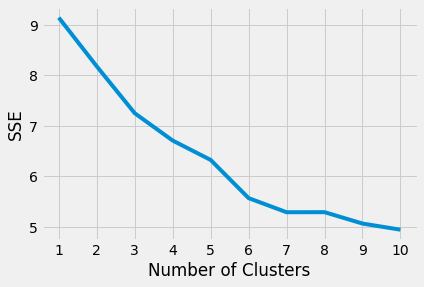

In [30]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

The optimal group number is determined by the convexity of the curve.

In [31]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

6

In [32]:
# set number of clusters
kclusters = kl.elbow

queens_grouped_clustering = queens_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=5).fit(queens_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 5, 4, 4, 5, 4, 4, 4, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 0, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5,
       5, 0, 5, 1, 0, 4, 0, 0, 0, 0, 0, 4, 4, 4, 0], dtype=int32)

Now we create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

queens_merged = queens_data
# merge cities_grouped with df_cities to add latitude/longitude for each city
queens_merged = queens_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

queens_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Astoria,40.768509,-73.915654,0,Hookah Bar,Middle Eastern Restaurant,Bar,Seafood Restaurant,Indian Restaurant,Greek Restaurant,Mediterranean Restaurant,Café,Bakery,Food Truck
1,Queens,Woodside,40.746349,-73.901842,0,Grocery Store,Bakery,Latin American Restaurant,Filipino Restaurant,Thai Restaurant,Pizza Place,Bar,American Restaurant,Pub,Donut Shop
2,Queens,Jackson Heights,40.751981,-73.882821,0,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Grocery Store,Thai Restaurant,Mobile Phone Shop,Mexican Restaurant,Pizza Place,Supplement Shop
3,Queens,Elmhurst,40.744049,-73.881656,0,Thai Restaurant,Mexican Restaurant,South American Restaurant,Bubble Tea Shop,Vietnamese Restaurant,Chinese Restaurant,Indonesian Restaurant,Colombian Restaurant,Snack Place,Malay Restaurant
4,Queens,Howard Beach,40.654225,-73.838138,0,Pharmacy,Italian Restaurant,Fast Food Restaurant,Sandwich Place,Breakfast Spot,Bus Station,Gym,Sushi Restaurant,Supermarket,Spa


## Results and Discussion

Finally, we can visualize the resulting clusters, where the neighborhoods with the same color are in the same group.


In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(queens_merged['Latitude'], queens_merged['Longitude'], queens_merged['Neighborhood'], queens_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>


#### Examine Clusters


Now, we examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

#### Cluster 1


In [35]:
queens_merged.loc[queens_merged['Cluster Labels'] == 0, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,Hookah Bar,Middle Eastern Restaurant,Bar,Seafood Restaurant,Indian Restaurant,Greek Restaurant,Mediterranean Restaurant,Café,Bakery,Food Truck
1,Woodside,Grocery Store,Bakery,Latin American Restaurant,Filipino Restaurant,Thai Restaurant,Pizza Place,Bar,American Restaurant,Pub,Donut Shop
2,Jackson Heights,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Grocery Store,Thai Restaurant,Mobile Phone Shop,Mexican Restaurant,Pizza Place,Supplement Shop
3,Elmhurst,Thai Restaurant,Mexican Restaurant,South American Restaurant,Bubble Tea Shop,Vietnamese Restaurant,Chinese Restaurant,Indonesian Restaurant,Colombian Restaurant,Snack Place,Malay Restaurant
4,Howard Beach,Pharmacy,Italian Restaurant,Fast Food Restaurant,Sandwich Place,Breakfast Spot,Bus Station,Gym,Sushi Restaurant,Supermarket,Spa
5,Corona,Mexican Restaurant,Supermarket,Convenience Store,Bakery,Park,Donut Shop,Restaurant,Empanada Restaurant,Chinese Restaurant,Sandwich Place
6,Forest Hills,Gym,Gym / Fitness Center,Yoga Studio,Convenience Store,Spa,Thai Restaurant,Pizza Place,Pharmacy,Park,Pool
7,Kew Gardens,Park,Chinese Restaurant,Italian Restaurant,Deli / Bodega,Pet Store,Pharmacy,Cosmetics Shop,Pizza Place,Donut Shop,Bar
8,Richmond Hill,Latin American Restaurant,Lounge,Bank,Pizza Place,Indian Restaurant,Pet Service,Spanish Restaurant,Caribbean Restaurant,Sandwich Place,Clothing Store
9,Flushing,Hotpot Restaurant,Korean Restaurant,Chinese Restaurant,Bubble Tea Shop,Gym / Fitness Center,Bakery,Asian Restaurant,Gym,Café,Construction & Landscaping


#### Cluster 2


In [36]:
queens_merged.loc[queens_merged['Cluster Labels'] == 1, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Somerville,Park,Yoga Studio,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market


#### Cluster 3


In [37]:
queens_merged.loc[queens_merged['Cluster Labels'] == 2, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
79,Bayswater,Playground,Yoga Studio,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Flea Market


#### Cluster 4


In [38]:
queens_merged.loc[queens_merged['Cluster Labels'] == 3, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,Neponsit,Beach,Yoga Studio,Fried Chicken Joint,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market


#### Cluster 5


In [39]:
queens_merged.loc[queens_merged['Cluster Labels'] == 4, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Glendale,Deli / Bodega,Pizza Place,Food & Drink Shop,Arts & Crafts Store,Brewery,Dim Sum Restaurant,Diner,French Restaurant,Food Truck,Food Stand
17,Woodhaven,Deli / Bodega,Pharmacy,Park,Bank,Bagel Shop,Mexican Restaurant,Pizza Place,Fried Chicken Joint,Nail Salon,Supermarket
19,South Ozone Park,Bar,Park,Fast Food Restaurant,Deli / Bodega,Hotel Bar,Hotel,Food,Food Truck,Sandwich Place,Donut Shop
21,Whitestone,Dance Studio,Deli / Bodega,Bubble Tea Shop,Candy Store,Fish Market,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop
27,Bellerose,Deli / Bodega,Italian Restaurant,Pizza Place,Diner,Flower Shop,Mobile Phone Shop,Gas Station,Seafood Restaurant,Salon / Barbershop,Bank
30,Briarwood,Deli / Bodega,Home Service,Bus Station,Gym,Coffee Shop,Indian Restaurant,Convenience Store,Cosmetics Shop,Playground,Dim Sum Restaurant
41,Far Rockaway,Deli / Bodega,Chinese Restaurant,Pizza Place,Grocery Store,Supermarket,Breakfast Spot,Bus Station,Fast Food Restaurant,Sandwich Place,Caribbean Restaurant
42,Broad Channel,Sandwich Place,Deli / Bodega,Pizza Place,Sporting Goods Shop,Bar,Other Nightlife,Dive Bar,Park,Harbor / Marina,Fast Food Restaurant
58,Lindenwood,Deli / Bodega,Japanese Restaurant,Pizza Place,Donut Shop,Fruit & Vegetable Store,Gym,Bank,Bakery,Spanish Restaurant,Hotel
64,Brookville,Deli / Bodega,Recording Studio,Yoga Studio,Fish & Chips Shop,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant


#### Cluster 6

In [40]:
queens_merged.loc[queens_merged['Cluster Labels'] == 5, queens_merged.columns[[1] + list(range(5, queens_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Breezy Point,Monument / Landmark,Trail,Beach,Bus Stop,Yoga Studio,Fish & Chips Shop,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
49,Rockaway Beach,Beach,Latin American Restaurant,Seafood Restaurant,Arepa Restaurant,Ice Cream Shop,BBQ Joint,Pizza Place,Outdoor Sculpture,Moving Target,Bed & Breakfast
61,Belle Harbor,Beach,Deli / Bodega,Spa,Pub,Mexican Restaurant,Donut Shop,Boutique,Chinese Restaurant,Bar,Bakery
62,Rockaway Park,Beach,Pizza Place,Donut Shop,Chinese Restaurant,Board Shop,Steakhouse,Bar,Bank,Bagel Shop,Seafood Restaurant
75,Roxbury,Beach,Deli / Bodega,Irish Pub,Fast Food Restaurant,Trail,Baseball Field,Bar,Pub,Food & Drink Shop,Food
78,Hammels,Beach,Fried Chicken Joint,Gym / Fitness Center,Diner,Dog Run,Exhibit,Fast Food Restaurant,Shoe Store,Bus Stop,Bus Station


We have used the k-means method to group the cities based on the common venues. 
Now we want to count the number of unique venues of each cluster among these most common venues. Notice that now we do not careabout the order of the most common venues anymore.
To get an overview we will make bar charts for the clusters 1,5,6. We exclude the other clusters from the further analysis, since they only contain one neighborhood.

In [45]:
most_venues=queens_merged.columns[list(range(5, queens_merged.shape[1]))]
dfz = pd.DataFrame(columns=['Group',"unique_values", "counts"])
for k in range(kclusters):
    dfx = pd.DataFrame(columns=["unique_values", "counts"])
    for x in most_venues:
        dfy = queens_merged[x].loc[queens_merged['Cluster Labels'] == k].value_counts().rename_axis('unique_values').reset_index(name='counts')
        dfx=dfx.append(dfy)
    values_count = dfx.groupby(['unique_values'])['counts'].agg('sum').rename_axis('unique_values').reset_index(name='counts')
    #values_count.head()
    values_count['Group']=k
    dfz=dfz.append(values_count)
    
dfz.sort_values(by=['counts'],inplace=True)

In [46]:
most_venues

Index(['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

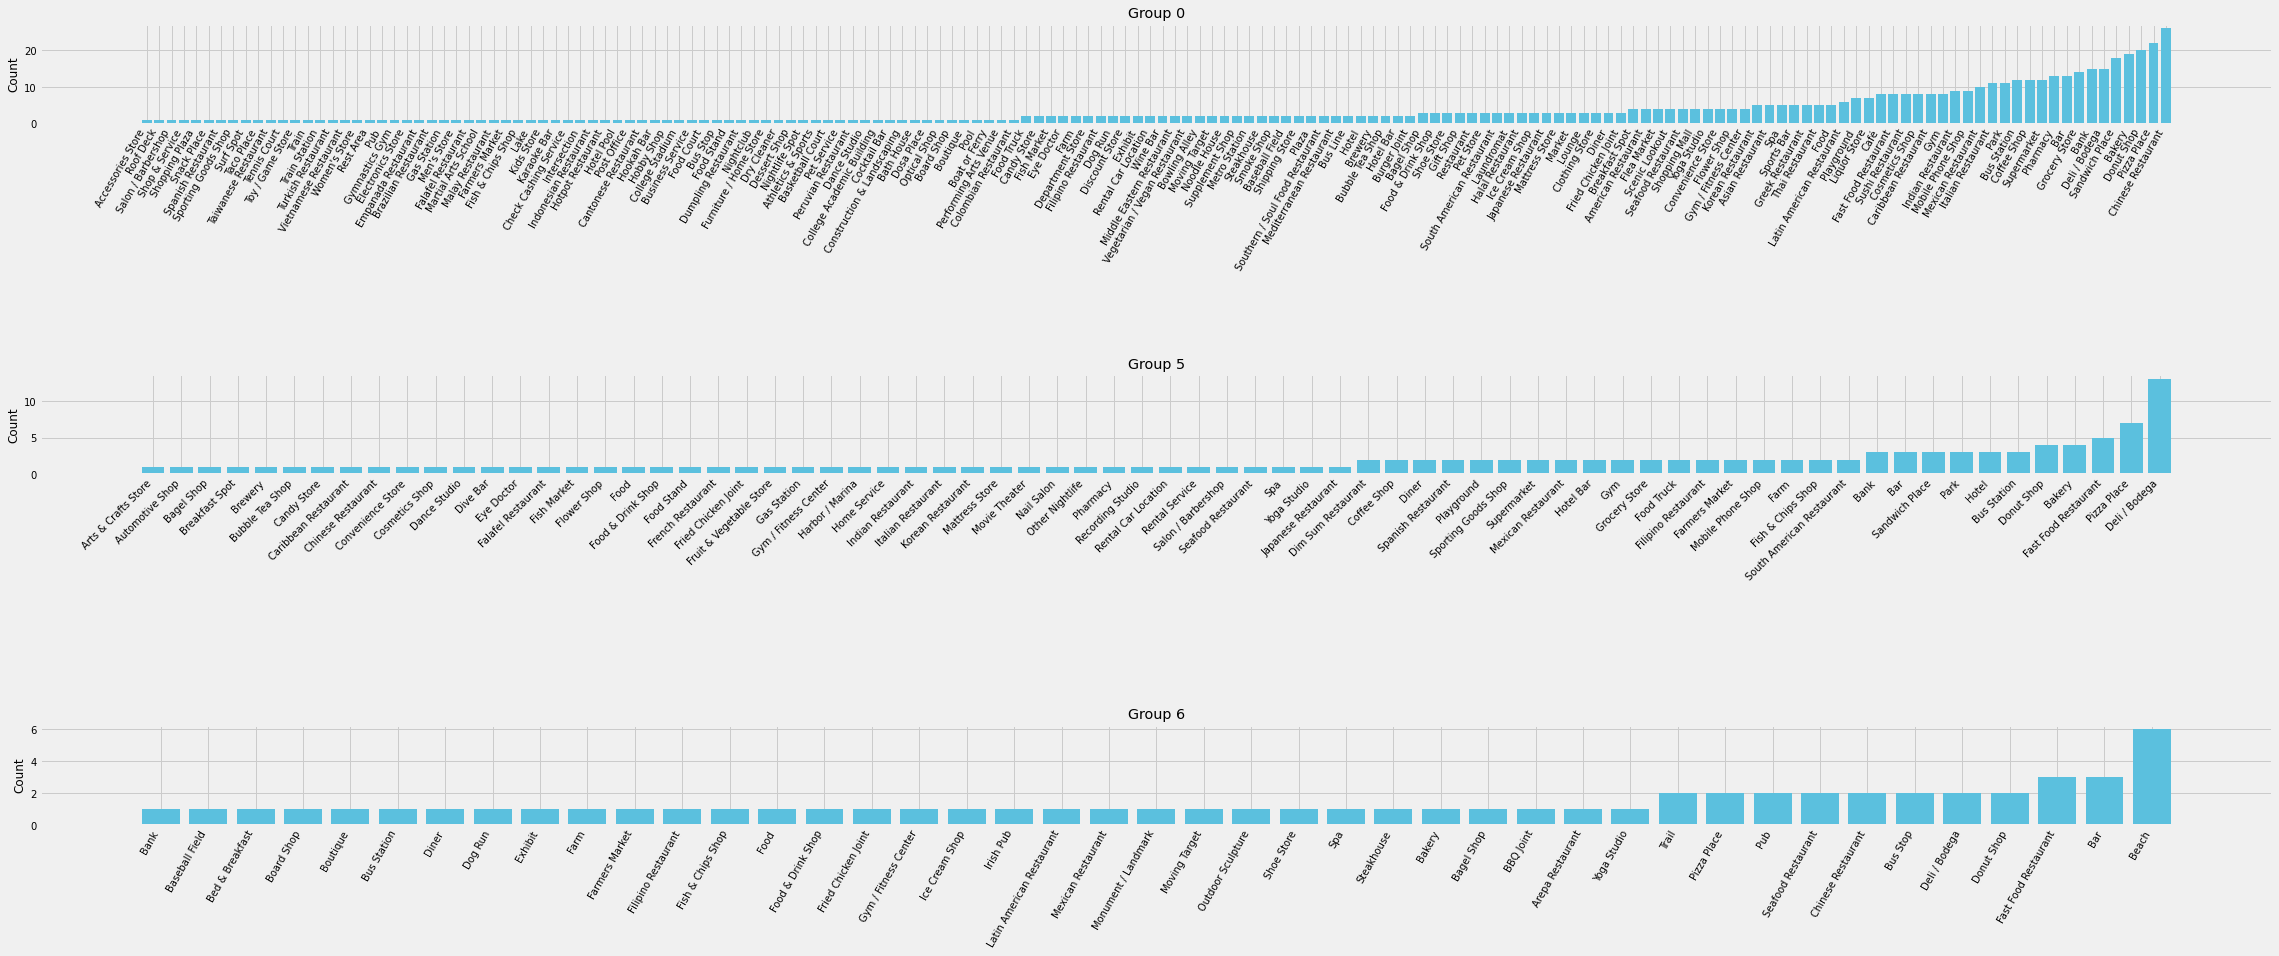

In [47]:
plt.figure(figsize=(40,20))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=2.5)

plt.subplot(411)
x = dfz['unique_values'].loc[dfz['Group']== 0]
count = dfz['counts'].loc[dfz['Group']== 0]

x_pos = [i for i, _ in enumerate(x)]

plt.rcParams.update({'font.size': 10})
plt.bar(x_pos, count, color='#5bc0de')
#plt.xlabel("Venue")
plt.ylabel("Count")
plt.title("Group 0")
plt.xticks(x_pos, x)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=60, horizontalalignment='right')

plt.subplot(412)

x = dfz['unique_values'].loc[dfz['Group']== 4]
count = dfz['counts'].loc[dfz['Group']== 4]

x_pos = [i for i, _ in enumerate(x)]


plt.bar(x_pos, count, color='#5bc0de')
#plt.xlabel("Venue")
plt.ylabel("Count")
plt.title("Group 5")

plt.rcParams.update({'font.size': 10})
plt.xticks(x_pos, x)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.subplot(413)

x = dfz['unique_values'].loc[dfz['Group']== 5]
count = dfz['counts'].loc[dfz['Group']== 5]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, count, color='#5bc0de')
#plt.xlabel("Venue")
plt.ylabel("Count")
plt.title("Group 6")

plt.rcParams.update({'font.size': 10})
plt.xticks(x_pos, x)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=60, horizontalalignment='right')

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=60, horizontalalignment='right')

plt.show()

We can observe that in cluster 5 and 6 fast food restaurants seem to be very popular, they appear with a high frequency among the most 10 common venues. 
Since the cities in the same group are similar, this leads to the conclusion that it could be a good choice to open a fast food restaurant in the neighboorhoods belonging to these two clusters, which do not already show fast food restaurants among the 10 most common venues.

## Conclusion

In this project we have analysed the neighborhoods in Queens and their most common venues. We have clustered the neighborhoods and found out which ones are similar.
We found that in two clusters, fast food restaurants are especially popular.

After analysing the data we have the following recomendation:
It would be a good choice to open new fast food restaurants in those neighborhoods that belong to cluster 5 and 6, but don't have a fast food restaurant among their 10 most common venues yet.